# Poisson Processes

Poisson process, model to describe events happening in random intervals. 

Example process is scoring goals in soccer

## World cup problem
2018 FIFA world cup, France defeated Croatia 4 to 2. Based on this:

1. How confident are we that France is the better team?
2. If the same teams played again, what is the odds France wins again?

Modeling assumptions:
- For any team to score against other team, there is some unknown goal scoring rate, lambda (lam)
- A goal is equally likely in any 1 minute of a game. So probability of scoring in any minute is lam/90.
- Assume the same team does not score twice in the same minute

None of the assumptions are fully true, but for soccer these assumptions are roughly true.

## Poisson Distribution

The poisson distribution formula for scoring k goals
> lam^k * exp(-lam) / k!

Scipy has a built in function poisson to help

In [1]:
from scipy.stats import poisson
lam = 1.4
dist = poisson(lam)
type(dist)

scipy.stats._distn_infrastructure.rv_frozen

In [2]:
#Object represents a frozen random variable and provides a pmf that can be evaluated
k = 4
dist.pmf(k)

#probability of scoring 4 goals in a game is ~4%

0.039471954028253146

In [3]:
#convert to pmf
from empiricaldist import Pmf
def make_poisson_pmf(lam, qs):
    """Make a Pmf of a Poisson distribution."""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

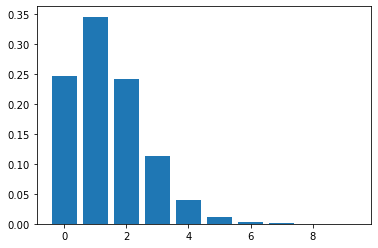

In [4]:
import numpy as np

lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)
pmf_goals.bar(label=r'Poisson distribution with $\lambda=1.4$')

Most likely outcome are 0, 1, 2, with higher values having lower chance.  Given goal scoring rate, we can predict the number of goals.

For the reverse, if we are given a number of goals, what can we say about the goal scoring rate?

Need to think about the prior distribution of lam, which is the range of values and probabilities before seeing the score.

## The Gamma Distribution

Soccer gives you some info for the distribution of lam.  Most games, teams score a few goals, with more than 5 being rare, and more than 10 being almost never.  lam = 1.4 was selected based on prior world cup scores.

We expect better teams to have to have better lam against worse teams and vice versa.

> To model the distribution of scores, we use the gamma distribution because
- Goal scoring rate is continuous and non negative (matching type of data appropriate for gamma distribution)
- Gamma distribution has one parameter
- Gamma distribution shape is reasonable given what we know about soccer

Gamma distribution is provided by scipy. gamma uses pdf object, which are the probability density functions.

In [5]:
#gamma distribution with alpha parameter set to 1.4
from scipy.stats import gamma

alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)

In [8]:
#Convert to Pmf
from empiricaldist import Pmf

prior = Pmf(ps, qs)
prior.normalize()

1.0

<AxesSubplot:>

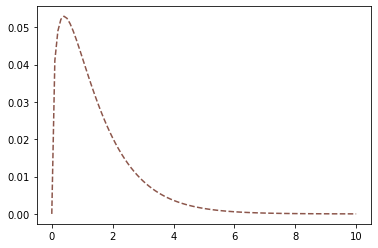

In [7]:
#plot
prior.plot(ls='--', label='prior', color='C5')

The distribution represents our prior knowledge about goal scoring: lam is usually less than 2, and rarely over 6.  People can disagree about details. The mean is near the 1.4 value.

In [10]:
prior.mean()

1.4140818156118378

## Update

Given the rate parameter(lam), calculate probability of scoring a particular number of goals.


In [11]:
#goals
lam = 1.4
k = 4
poisson(lam).pmf(4)

0.039471954028253146

In [12]:
#For array of possible lams
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)

To update and get the posterior distribution.  Multiply priors likelihood then normalize the results.

In [13]:
def update_poisson(pmf, data):
    """Update Pmf with a Poisson likelihood."""
    k = data
    lams = pmf.qs
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    pmf.normalize()

pmf is the prior, and data is the number of goals.

If france score 4 goals

In [14]:
france = prior.copy()
update_poisson(france, 4)

<AxesSubplot:>

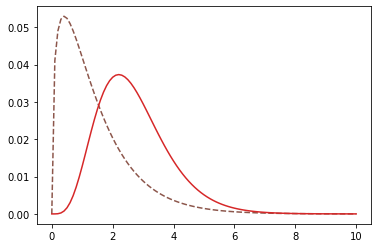

In [15]:
prior.plot(ls='--', label='prior', color='C5')
france.plot(label='France posterior', color='C3')


The data points towards the value of lam being higher is more likely, and lower values are less likely, so the distribution shifts to the right.

<AxesSubplot:>

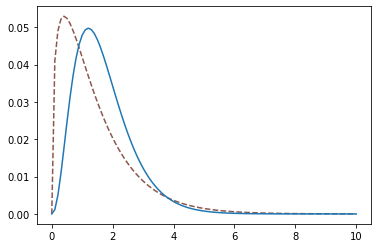

In [17]:
#same for croatia
croatia = prior.copy()
update_poisson(croatia, 2)
prior.plot(ls='--', label='prior', color='C5')
croatia.plot(label='Croatia posterior', color='C0')

In [18]:
#print mean distribution
print(croatia.mean(), france.mean())


1.6999765866755225 2.699772393342308


## Probability of superiority

How confident can we be that france is the better team?

What are the odds that a random value pulled from France's distribution will exceed that of Croatia?


In [19]:
#Enumerate all values from the distribution then sum the total probability that one value exceeds the other
def prob_gt(pmf1, pmf2):
    """Compute the probability of superiority."""
    total = 0
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            if q1 > q2:
                total += p1 * p2
    return total

In [20]:
prob_gt(france, croatia)

0.7499366290930155

In [21]:
#use PMF function
Pmf.prob_gt(france, croatia)

0.7499366290930174

Both around 75% (difference due to array vs loop arthimatic).  Moderate confidence that Frances has higher score. However, assumptions may be violated, goal-scoring rate being constant. Teams may play more aggressively toward the end of the game or may be more lax.  

# Predict a rematch

If the same teams played again, what are Croatia's chances of winning?  Need to generate a posterior predictive distribution (number of goals expect to score).

See what a few different values of lam look like

In [23]:
pmf_seq = [make_poisson_pmf(lam, goals)
            for lam in prior.qs]

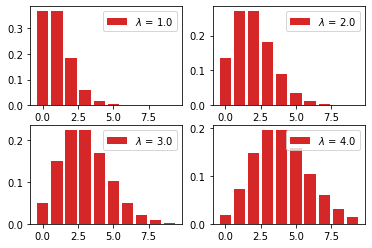

In [27]:
import matplotlib.pyplot as plt

for i, index in enumerate([10, 20, 30, 40]):
    plt.subplot(2, 2, i+1)
    lam = prior.qs[index]
    pmf = pmf_seq[index]
    pmf.bar(label=f'$\lambda$ = {lam}', color='C3')
    plt.legend()

The predictive distribution is a mixture of these distributions, weighted with posterior probabilities.  

In [30]:
#from last chapter
import pandas as pd

def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

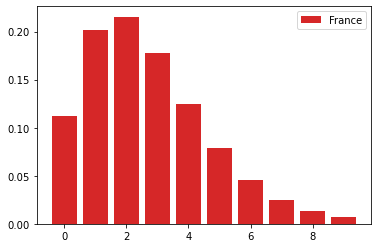

In [33]:
pred_france = make_mixture(france, pmf_seq)
pred_france.bar(color='C3', label='France')
plt.legend()

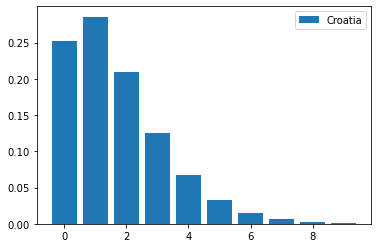

In [42]:
pred_croatia = make_mixture(croatia, pmf_seq)
pred_croatia.bar(color='C0', label='Croatia')
plt.legend()

In [44]:
#check odds France wins
win = Pmf.prob_gt(pred_france, pred_croatia)
win

0.5703522415934519

In [45]:
#Check probabilities France loses
lose = Pmf.prob_lt(pred_france, pred_croatia)
lose

0.26443376257235873

In [46]:
#Check probs France ties
tie = Pmf.prob_eq(pred_france, pred_croatia)
tie

0.16521399583418947

In [47]:
#If france wins half the ties
win + tie/2

0.6529592395105466

Lower prob than prob for superiority, less confident in the outcome of one game compared to the general goal scoring rates.

# Exponential Distrobution

Problem 
> 2014 world cup, Germany vs Brazil
>Germany scored after 11 minutes and again at 23 minutes, at that point in the match, how many goals do you expect Germany to score after 90 minutes. What was the probability that they would score 5 more goals (which happened)



In this problem, the data is not the number of goals in a fixed period of time, but the time between goals being scored.

To compute this likelihood, can use Poisson processes again. 
> If each team has a constant goal scoring rate, then we expect time between goals to follow an exponetial distribution. With rate lamda, probability of seeing an interval between occurances of t is propoortional to the PDF of the exponential distribution. 

- lam * exp (-lam * t)

> t is continous, so the value is not a probability, but a probability density, which is proporitional to the probability, so it can still be used in bayesian updates.

Scipy has a function called expon, that creates an object with exponetial distribution.  It doesn't take lam as a parameter, so need to modify.

In [48]:
def expo_pdf(t, lam):
    """Compute the PDF of the exponential distribution."""
    return lam * np.exp(-lam * t)

In [51]:
#distribution with  lam = 1.4
lam = 1.4
qs = np.linspace(0, 4, 101)
ps = expo_pdf(qs, lam)
pmf_time = Pmf(ps, qs)
pmf_time.normalize()

25.616650745459093

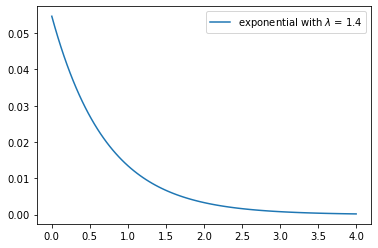

In [53]:
pmf_time.plot(label='exponential with $\lambda$ = 1.4')
plt.legend()

The most likely time to score a goal is immediately, and it decreases with time

# Excercises
### Excercise 1
Finish Germany vs Brazil world cup
Hints: 
1. Using gamma prior compute likelihood of scoring a goal after 11 min for each value of lam
2. Compute posterior distribution of lam for Germany after first goal
3. Compute likelihood of scoring another goal after 12 more minutes
4. Compute posterior predictive distribution of goals
5. Compute probability of scoring 5 or more gals in the remaining time


In [54]:
def update_expo(pmf, data):
    """Update based on an observed interval
    pmf: prior PMF
    data: time between goals in minutes
    """
    t = data / 90
    lams = pmf.qs
    likelihood = expo_pdf(t, lams)
    pmf *= likelihood
    pmf.normalize()

In [55]:
#update 1st and 2nd goal for germany
germany = prior.copy()
update_expo(germany, 11)
germany2 = germany.copy()
update_expo(germany2, 12)

In [56]:
#Mean values of lam after each update
germany.mean(), germany2.mean()


(2.1358882653086892, 2.703059034926364)

Text(0.5, 1.0, 'Prior and Posterior distributions')

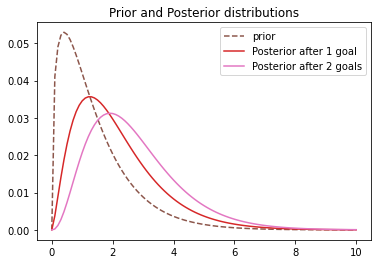

In [58]:
#Plot distrubtions after each update 
prior.plot(ls='--', label='prior', color='C5')
germany.plot(color='C3', label='Posterior after 1 goal')
germany2.plot(color='C16', label='Posterior after 2 goals')
plt.legend()
plt.title("Prior and Posterior distributions")

In [60]:
#Predictive distribution for each value of lam
t = (90-23) / 90
pmf_seq = [make_poisson_pmf(lam * t, goals)
           for lam in germany2.qs]

Text(0.5, 1.0, 'Posterior predictive distribution')

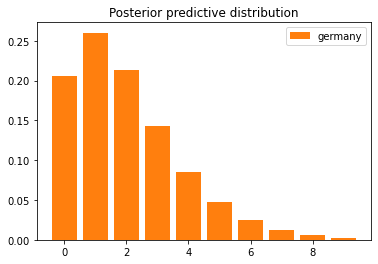

In [63]:
#Mixture of predictive distributions
pred_germany2 = make_mixture(germany2, pmf_seq)
pred_germany2.bar(color='C1', label='germany')
plt.legend()
plt.title('Posterior predictive distribution')

In [68]:
#Probs of Germany getting 5 more goals
pred_germany2[5]

0.047109658706113416

In [69]:
#Prob greater than or equal to 5
pred_germany2.prob_ge(5)

0.09286200122834538

### Exercise 2
Suppose France and Croatia have a rematch, what is the probability that France scores first?

In [70]:
#pmf predictive distribution
def make_expo_pmf(lam, high):
    qs = np.linspace(0, high, 101)
    ps = expo_pdf(qs, lam)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [71]:
#predictive distribution for time to first goal
pmf_seq = [make_expo_pmf(lam, high=4) for lam in prior.qs]


In [72]:
#make distribution for two posterior
pred_france = make_mixture(france, pmf_seq)
pred_croatia = make_mixture(croatia, pmf_seq)

Text(0.5, 1.0, 'France v Croatia, first goal: Posterior predictive distribtuion')

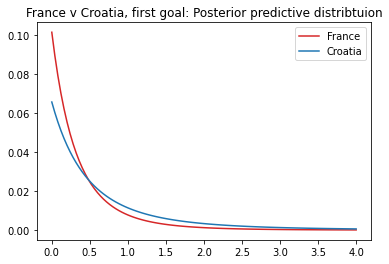

In [73]:
#plot
pred_france.plot(label='France', color='C3')
pred_croatia.plot(label='Croatia', color='C0')
plt.legend()
plt.title("France v Croatia, first goal: Posterior predictive distribtuion")